# Detecting DOS attacks using python

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import sys
import asyncio 

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())


In [4]:
data = pd.read_csv('dataset.csv')

## Analzying dataset

In [5]:
data.head()

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket
0,0,38.57.146.249,True,12,notification,2022-01-02T03:31:34.498Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
3,3,228.143.56.163,True,12,notification,2022-01-02T03:44:36.548Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0


Based on the column names and sample data provided, here is what I can infer about the dataset:

- **Id**: Unique identifier for each row
- **IP**: IP address of the request
- **bot**: Indicates if the request is from a bot or not
- **FunctionId**: ID for the function being invoked
- **functionTrigger**: Indicates what triggered the function execution
- **timestamp**: Timestamp of when the function execution started
- **SubmitTime**: Time when the request was submitted
- **RTT**: Round trip time for the request
- **InvocationDelay**: Delay between request submission and function invocation
- **ResponseDelay**: Delay for the response after function execution
- **FunctionDuration**: Total time taken for function execution
- **ActiveFunctionsAtRequest**: Number of functions active when the request came
- **ActiveFunctionsAtResponse**: Number of functions active when the response was sent
- **maxcpu**: Maximum CPU utilization
- **avgcpu**: Average CPU utilization
- **p95maxcpu**: 95th percentile of max CPU
- **vmcategory**: VM category
- **vmcorecountbucket**: Number of CPU cores for VM
- **vmmemorybucket**: Memory allocation for VM

To detect DOS attacks on this data, some analyses you could do:

- Check for spikes or sudden increases in the number of requests per minute from an IP.
- Analyze FunctionDuration to detect abnormal execution times.
- Look for high InvocationDelay or ResponseDelay as signs of an overloaded system.
- Plot trends for avgcpu and maxcpu to detect sudden spikes in resource utilization.
- Train anomaly detection models like Isolation Forest on metrics like request counts, delays, and resource utilization.
- Compare metrics like VM cores and memory to load, like active functions and CPU use, to detect overloaded VMs.

So in summary, time-series analysis, correlation analysis, and anomaly detection on metrics like request rate, delays, and resource usage can help uncover DOS attacks.


In [6]:
data.shape

(187087, 19)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187087 entries, 0 to 187086
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Id                         187087 non-null  int64  
 1   IP                         187087 non-null  object 
 2   bot                        187087 non-null  bool   
 3   FunctionId                 187087 non-null  int64  
 4   functionTrigger            187087 non-null  object 
 5   timestamp                  187087 non-null  object 
 6   SubmitTime                 187087 non-null  int64  
 7   RTT                        187087 non-null  int64  
 8   InvocationDelay            187087 non-null  float64
 9   ResponseDelay              187087 non-null  float64
 10  FunctionDuration           187087 non-null  float64
 11  ActiveFunctionsAtRequest   187087 non-null  int64  
 12  ActiveFunctionsAtResponse  187087 non-null  int64  
 13  maxcpu                     18

## Label Distribution Analysis: Benign vs. Malicious Data

In [9]:
### Here we see that the label contains boolean values: False - Benign, True-Maliciuous 
data.bot.unique()

array([ True, False])

In [10]:
data.bot.value_counts()

True     131072
False     56015
Name: bot, dtype: int64

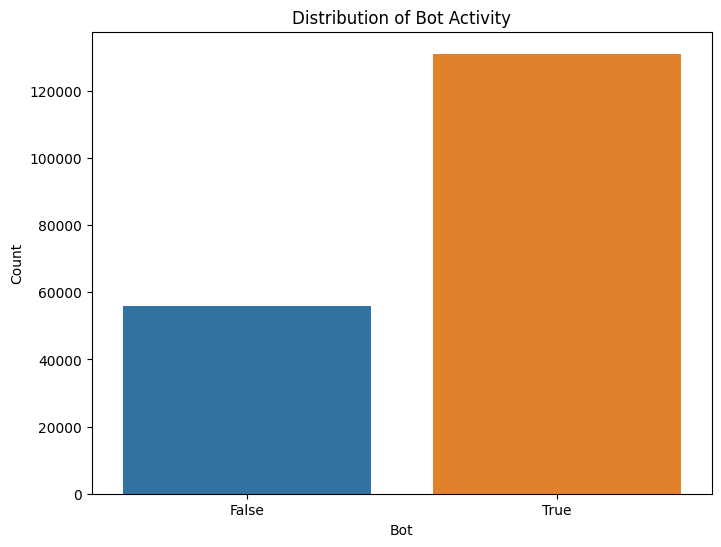

In [11]:
# Bar plot of bot activity
plt.figure(figsize=(8, 6))
sns.countplot(x='bot', data=data)
plt.title('Distribution of Bot Activity')
plt.xlabel('Bot')
plt.ylabel('Count')
plt.show()

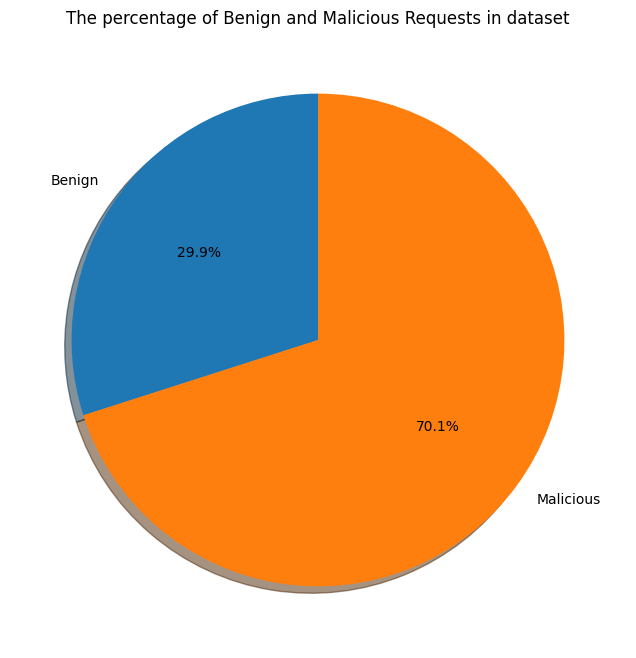

In [12]:
labels = ["Benign", "Malicious"]  # Corrected order of labels
sizes = [data['bot'].value_counts()[False], data['bot'].value_counts()[True]]  # Corrected calculation

plt.figure(figsize=(13, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('The percentage of Benign and Malicious Requests in dataset')
plt.show()


## Box plot of traffic volume by bot activity

The round-trip time (RTT) in the context of network communication refers to the time it takes for a packet of data to travel from a source to a destination and back again. It is a measure of the latency or delay experienced in transmitting data over a network.

In the given analysis, the box plot of RTT by bot activity compares the distribution of RTT values between benign and malicious bot activities. By examining the box plot, you can understand the typical RTT values associated with each type of bot activity and identify any differences or patterns in their distribution. This information can be useful for network analysis, performance optimization, and identifying potential anomalies or malicious behavior in network traffic.

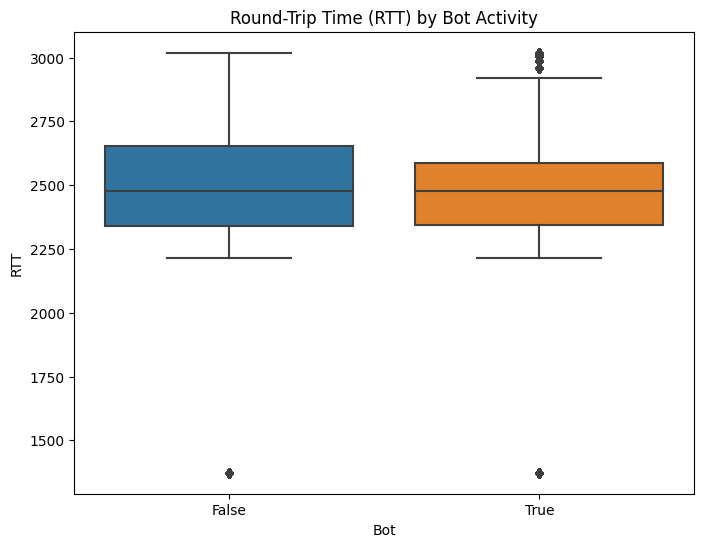

In [13]:
# Box plot of traffic volume by bot activity
plt.figure(figsize=(8, 6))
sns.boxplot(x='bot', y='RTT', data=data)
plt.title('Round-Trip Time (RTT) by Bot Activity')
plt.xlabel('Bot')
plt.ylabel('RTT')
plt.show()

### Correlation Between Bot Activity and Other Features

Inferences:
- The heatmap displays the correlation coefficients between the 'bot' activity and other features in the dataset.
- Features with correlation coefficients closer to 1 indicate a stronger positive correlation with bot activity, while coefficients closer to -1 indicate a stronger negative correlation.
- Features positively correlated with bot activity may have a higher influence on the presence of botnet behavior, while negatively correlated features may be less associated with bot activity.
- Analyzing the correlation coefficients can provide insights into which features are most relevant for predicting or detecting bot activity in the network traffic data.
- Features with higher positive correlation coefficients may be potential indicators of malicious bot behavior and could be prioritized for further investigation or feature engineering in botnet detection algorithms.

<Axes: >

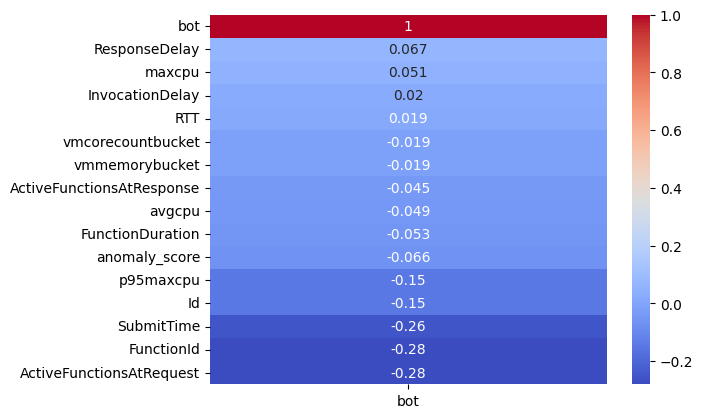

In [53]:
# Heatmap of correlation between bot activity and other features
sns.heatmap(data.corr(numeric_only=True)[['bot']].sort_values(by='bot', ascending=False), annot=True, cmap='coolwarm')


In [15]:
data.describe()

,Id,FunctionId,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket
count,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000
mean,93543.000000,28.592569,85.841250,2494.167083,1239.287586,165.658396,1089.373666,28.592569,996.465741,97.050470,31.440571,88.441047,4.776297,31.000653
std,54007.509243,13.777358,11.968575,286.236688,299.874337,42.838260,62.326101,13.777358,3.010734,5.018163,17.386644,20.042926,3.489087,27.057633
min,0.000000,2.000000,71.000000,1373.000000,170.746338,117.803711,1031.168938,2.000000,988.000000,78.776399,1.350084,7.924250,1.000000,0.750000
25%,46771.500000,17.000000,75.000000,2344.000000,1060.574707,134.759521,1059.582233,17.000000,994.000000,96.017207,19.830185,89.853209,1.000000,1.750000
50%,93543.000000,30.000000,79.000000,2476.000000,1205.249512,145.178711,1074.904203,30.000000,998.000000,99.356190,33.304020,95.297275,8.000000,56.000000
75%,140314.500000,40.000000,98.000000,2593.000000,1388.304443,203.505127,1099.621534,40.000000,999.000000,99.566656,41.804117,98.110481,8.000000,56.000000
max,187086.000000,50.000000,102.000000,3019.000000,1800.190674,247.116455,1437.139511,50.000000,999.000000,100.000000,92.503412,99.586511,8.000000,56.000000


## Visualization of Null Values in Features
The bar plot above illustrates the count of null values in each feature of the dataset. Here are some key points:

- Features with null values are represented on the x-axis, and the corresponding count of null values is shown on the y-axis.
- The height of each bar represents the number of missing values in the respective feature.
- Analyzing the distribution of null values across features is essential for understanding data completeness and deciding on appropriate strategies for handling missing data.
- Features with a higher count of null values may require imputation techniques or further investigation to understand the reason for missingness.
- Identifying features with a large number of null values can inform data preprocessing steps and help ensure the reliability and accuracy of downstream analyses.







Text(0.5, 1.0, 'Features which has NuLL values')

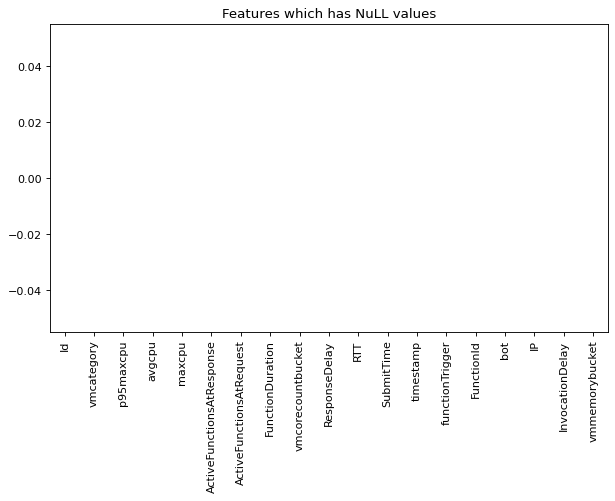

In [16]:
# Let's look at the vizualisation of Null valued features
figure(figsize=(9, 5), dpi=80)
data[data.columns[data.isna().sum() >= 0]].isna().sum().sort_values().plot.bar()
plt.title("Features which has NuLL values")

In [17]:
data.isnull().sum()

Id                           0
IP                           0
bot                          0
FunctionId                   0
functionTrigger              0
timestamp                    0
SubmitTime                   0
RTT                          0
InvocationDelay              0
ResponseDelay                0
FunctionDuration             0
ActiveFunctionsAtRequest     0
ActiveFunctionsAtResponse    0
maxcpu                       0
avgcpu                       0
p95maxcpu                    0
vmcategory                   0
vmcorecountbucket            0
vmmemorybucket               0
dtype: int64

### Identification of Numeric and Object Columns

In [18]:
#### Let's support which columns NUMERIC and which is OBJECT

numeric_df = data.select_dtypes(include=['int64', 'float64'])
object_df = data.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['Id', 'FunctionId', 'SubmitTime', 'RTT', 'InvocationDelay',
       'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object') 

Object Columns: 
Index(['IP', 'functionTrigger', 'timestamp', 'vmcategory'], dtype='object') 

Number of Numeric Features:  14
Number of Object Features:  4


In [19]:
object_df.head()

,IP,functionTrigger,timestamp,vmcategory
0,38.57.146.249,notification,2022-01-02T03:31:34.498Z,Delay-insensitive
1,55.220.132.116,notification,2022-01-02T03:54:53.136Z,Delay-insensitive
2,141.232.38.48,notification,2022-01-02T03:38:31.950Z,Delay-insensitive
3,228.143.56.163,notification,2022-01-02T03:44:36.548Z,Delay-insensitive
4,223.113.21.186,notification,2022-01-02T03:52:54.326Z,Delay-insensitive


### Analysis of Requests per IP Address

The code provided calculates the number of requests made by each unique IP address in the dataset. Here are the inferences:

- The number of requests made by each IP address is displayed.
- By analyzing the count of requests per IP address, we can identify any unusual patterns or potentially suspicious activity originating from specific IP addresses.
- This information can be valuable for network security analysis, identifying potential DDoS attacks, or understanding the distribution of traffic from different sources.


In [20]:
# Count the number of requests per IP address
requests_per_ip = data['IP'].value_counts()

# Display the count for each IP address
print(requests_per_ip)


158.135.184.38    2159
190.50.77.86      2155
142.45.98.176     2070
227.200.85.209    1800
84.243.175.245    1800
                  ... 
204.99.250.152       1
38.250.139.62        1
214.88.87.14         1
211.253.165.77       1
58.147.76.78         1
Name: IP, Length: 7587, dtype: int64


In [21]:
requests_per_ip.head(150)

158.135.184.38     2159
190.50.77.86       2155
142.45.98.176      2070
227.200.85.209     1800
84.243.175.245     1800
                   ... 
6.235.225.120         9
246.18.196.15         9
81.100.115.207        9
50.59.151.158         9
243.134.193.194       9
Name: IP, Length: 150, dtype: int64

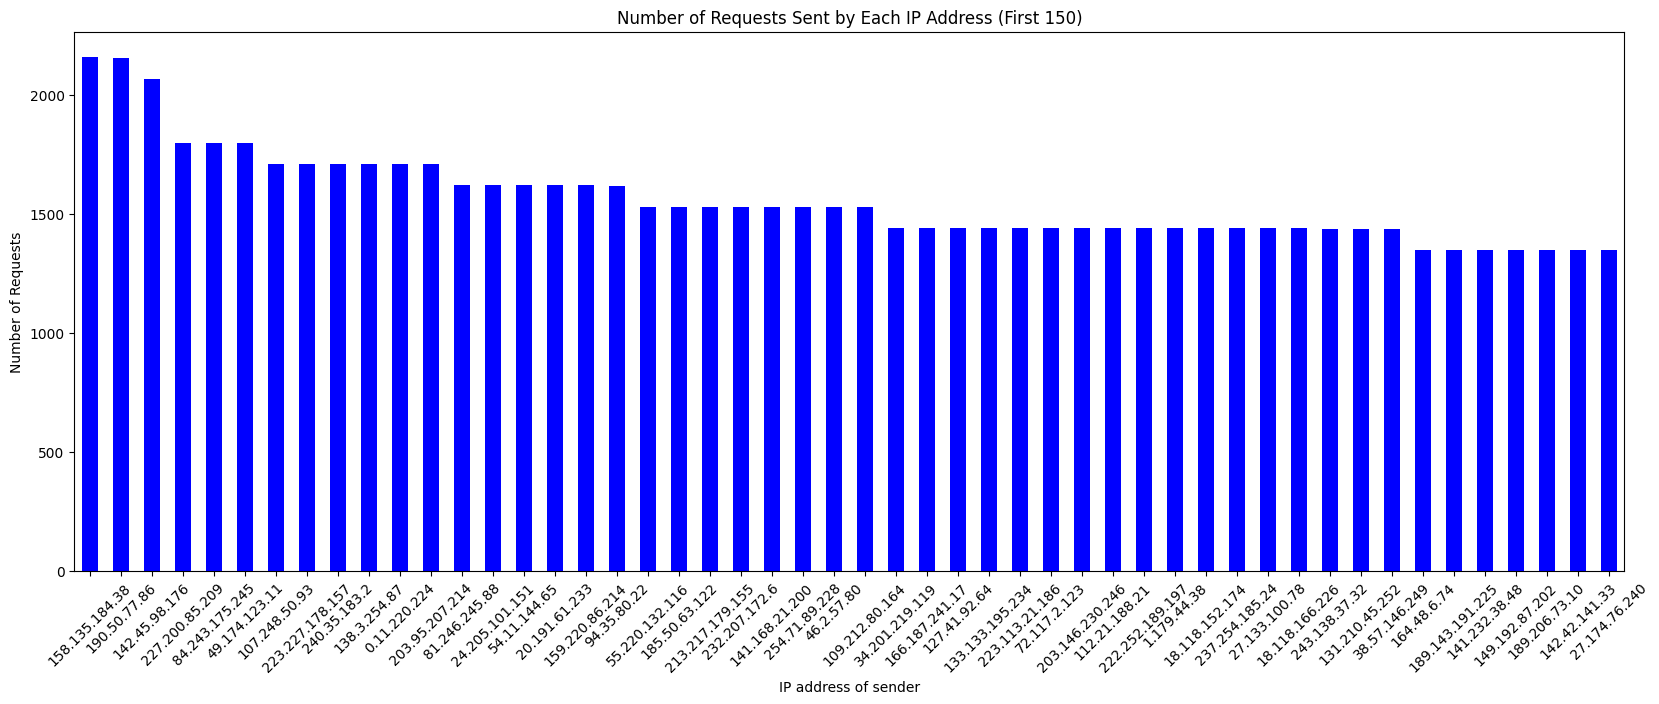

In [22]:
# Select the first 50 entries of requests_per_ip
requests_per_ip_subset = requests_per_ip.head(50)

# Plot the counts of requests for the first 50 IP addresses
plt.figure(figsize=(20, 7))
requests_per_ip_subset.plot(kind='bar', color='blue')
plt.xlabel('IP address of sender')
plt.ylabel('Number of Requests')
plt.title('Number of Requests Sent by Each IP Address (First 150)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


### Analysis of Attack Requests by IP Bot Address

The provided code calculates the number of attack requests made by each unique IP bot address in the dataset. Here are the inferences:

- The count of attack requests per IP bot address is displayed.
- By analyzing this information, we can identify the IP addresses associated with malicious bot activity.
- This insight is crucial for detecting and mitigating potential cybersecurity threats, such as botnet attacks or other forms of malicious activity.


In [23]:
# Number of attack requests by each IP bot address
subset_data = data[data['bot'] == True]['IP'].value_counts()
print(subset_data)


158.135.184.38     2159
190.50.77.86       2155
142.45.98.176      2070
84.243.175.245     1800
227.200.85.209     1800
                   ... 
212.133.126.132     720
206.191.90.105      711
43.198.161.62       630
40.57.198.164       360
46.240.71.108       270
Name: IP, Length: 100, dtype: int64


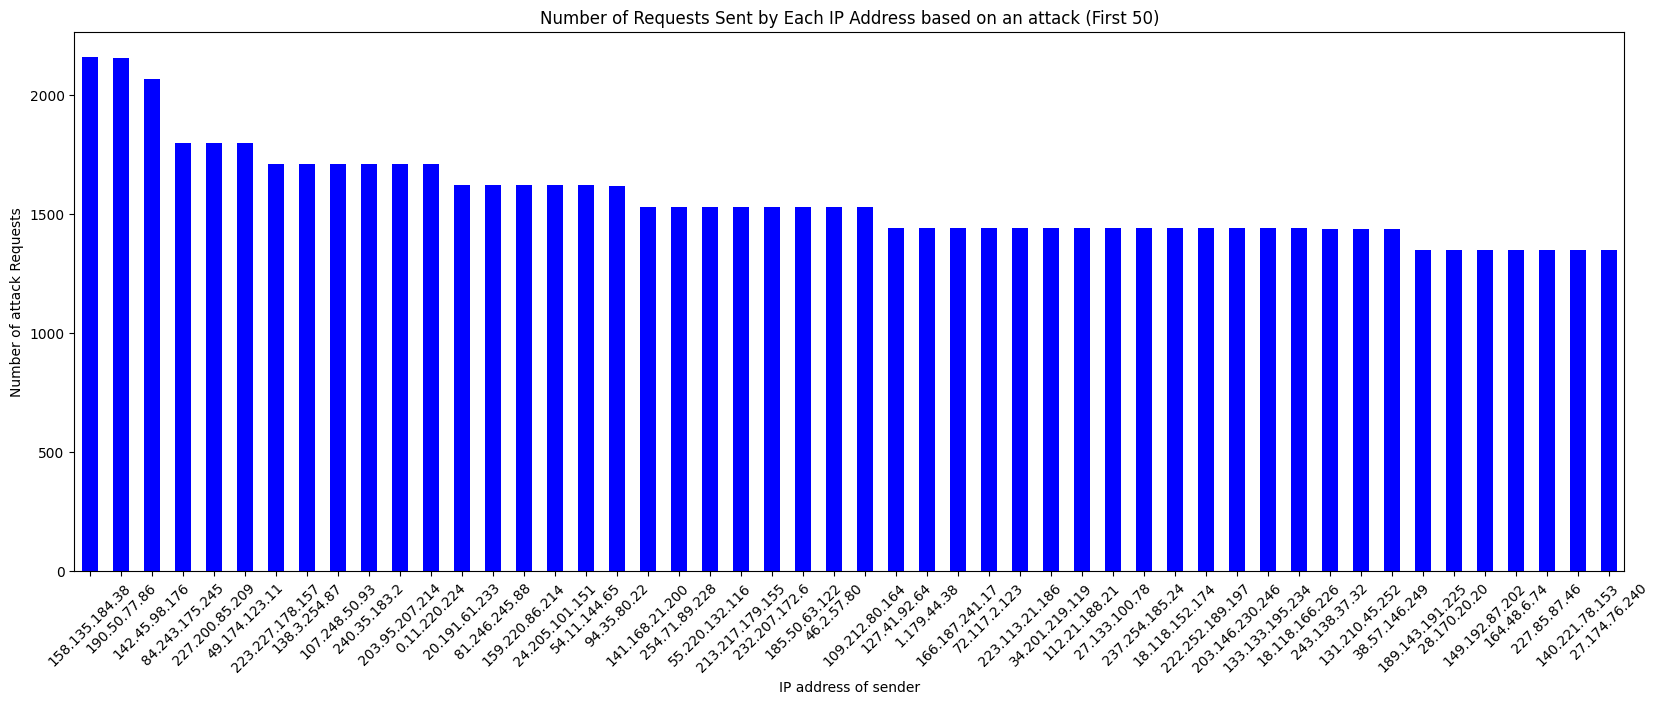

In [24]:
# Select the first 50 entries of requests_per_ip
subset_data_trun = subset_data.head(50)

plt.figure(figsize=(20, 7))
subset_data_trun.plot(kind='bar', color='blue')
plt.xlabel('IP address of sender')
plt.ylabel('Number of attack Requests')
plt.title('Number of Requests Sent by Each IP Address based on an attack (First 50)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [25]:
data.columns

Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')

### Anomaly Detection in Round-Trip Time (RTT)

The provided code demonstrates the process of anomaly detection in the Round-Trip Time (RTT) feature using the Isolation Forest algorithm. Here's an overview:

1. **Isolation Forest Model**: An Isolation Forest model is trained on the RTT data with a contamination rate of 5% to identify anomalies.
   
2. **Predict Anomalies**: The trained model is used to predict anomalies in the RTT data.
   
3. **Plot Anomalies**: The RTT data is visualized over time, and anomalies detected by the Isolation Forest model are highlighted in red.

This analysis helps to identify unusual or unexpected patterns in the RTT, which may indicate potential network issues or abnormal behavior requiring further investigation.


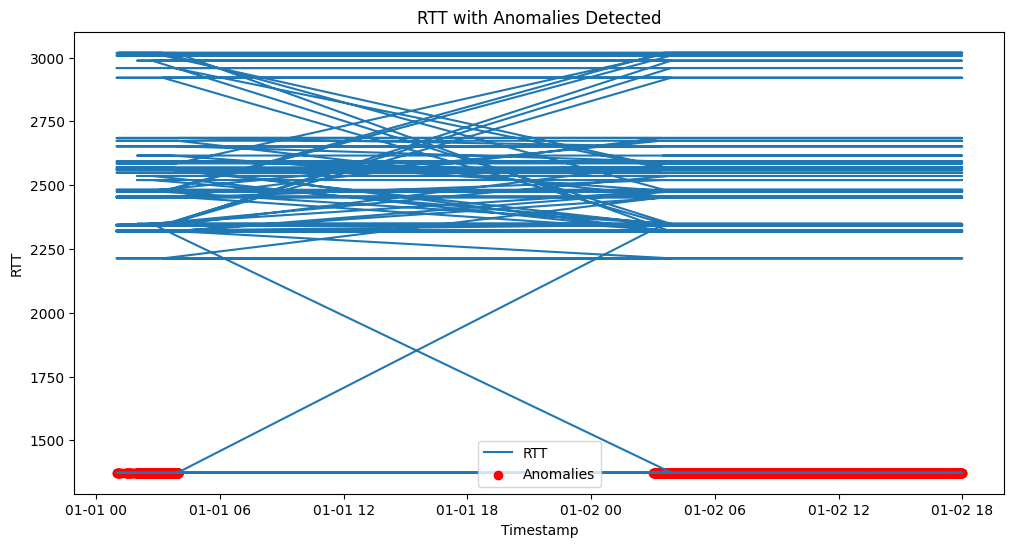

In [36]:
# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest model
model = IsolationForest(contamination=0.05)
model.fit(data[['RTT']])

# Predict anomalies
anomalies = model.predict(data[['RTT']])

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RTT'], label='RTT')
plt.scatter(data.index[anomalies == -1], data['RTT'][anomalies == -1], color='red', label='Anomalies')
plt.title('RTT with Anomalies Detected')
plt.xlabel('Timestamp')
plt.ylabel('RTT')
plt.legend()
plt.show()

### Visualization: Requests Per Minute (RPM)

The provided code snippet visualizes the number of requests per minute (RPM) over time. Here's a breakdown of the steps:

1. **Data Preprocessing**:
   - The 'timestamp' column is converted to datetime type, ensuring proper handling of time data.
   - The 'timestamp' is then floored to the nearest minute to aggregate data at a minute level.
   - The 'minute' column is set as the index for further analysis.

2. **Grouping and Aggregation**:
   - The data is grouped by minute using the `pd.Grouper` function with a frequency of 1 minute ('1T').
   - The number of requests per minute is counted.

3. **Visualization**:
   - The RPM data is plotted over time.
   - The x-axis represents time (in minutes), while the y-axis represents the number of requests.
   - The plot provides insights into the overall request traffic pattern and any potential trends or anomalies over time.


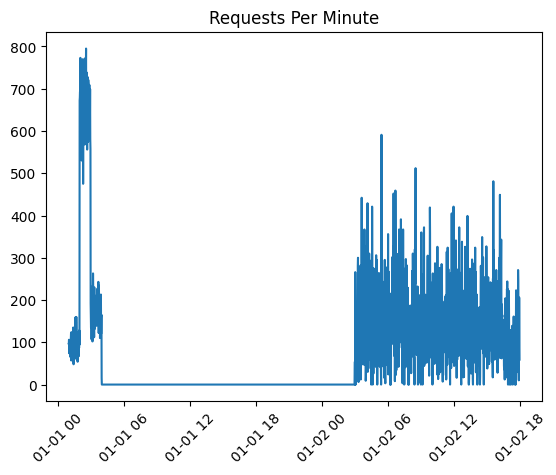

In [37]:
# Convert 'timestamp' column to datetime type
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)

# Floor the 'timestamp' to the nearest minute
data['minute'] = data['timestamp'].dt.floor('1T')

# Set the 'minute' column as the index
data = data.set_index('minute')
 
# Group data by minute and count the number of requests per minute
rpm = data.groupby(pd.Grouper(freq='1T')).count()['IP']

# Plot Requests Per Minute (RPM)
plt.plot(rpm)
plt.title('Requests Per Minute')
plt.xticks(rotation=45)
plt.show()


### Anomaly Detection and Correlation Analysis

#### Anomaly Detection Based on Requests Per Minute (RPM):
- An Isolation Forest model is trained using the Requests Per Minute (RPM) data to detect anomalies in request traffic patterns.
- The trained model is applied to the RPM data, and anomalies are identified based on a threshold (e.g., scores below -0.5).
- Anomalies in the RPM data are printed for further analysis.

#### Correlation Analysis:
- The code snippet calculates the correlation matrix for all features in the dataset.
- A heatmap is then plotted to visualize the correlations between different features.
- The heatmap provides insights into the relationships between variables, with stronger correlations represented by warmer (positive) or cooler (negative) colors.

#### Anomaly Detection Based on Feature Relationships:
- An Isolation Forest model is applied to specific features ('FunctionDuration' and 'avgcpu') to detect anomalies in their relationships.
- The model assigns anomaly scores to each data point based on its deviation from normal behavior.
- Data points with anomaly scores below -0.5 are identified as anomalies and are extracted from the dataset for further investigation.


Series([], Freq: T, Name: IP, dtype: int64)


,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,anomaly_score
minute,,,,,,,,,,,,,,,,,,,,


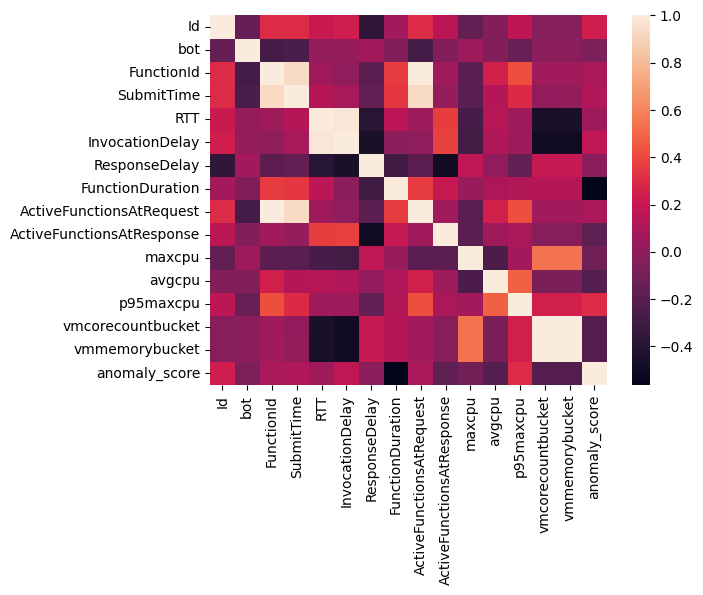

In [55]:
# Anomaly detection for rpm
rpm_model = IsolationForest(n_estimators=100)
rpm_model.fit(rpm.values.reshape(-1, 1))  # Reshaping to convert to a 2D array
rpm_scores = rpm_model.decision_function(rpm.values.reshape(-1, 1))  
rpm_anoms = rpm[rpm_scores < -0.5]
print(rpm_anoms)

# Correlation analysis
corr = data.corr(numeric_only=True)  
sns.heatmap(corr)

# Anomaly detection for 'FunctionDuration' and 'avgcpu'
X = data[['FunctionDuration', 'avgcpu']].values  # Converting to NumPy array
clf = IsolationForest(n_estimators=100)
clf.fit(X)
data['anomaly_score'] = clf.decision_function(X) 
data[data['anomaly_score'] < -0.5]


### Resource Utilization Over Time

The plot above illustrates the average CPU and memory utilization over time.

- The x-axis represents time, while the y-axis represents utilization.
- The blue line represents CPU utilization, and the orange line represents memory utilization.
- Overall, both CPU and memory utilization seem to fluctuate over time, indicating varying levels of resource usage.
- Peaks and valleys in the plot may correspond to periods of increased or decreased resource demand.
- Analyzing resource utilization trends can provide insights into system performance and capacity planning, helping to optimize resource allocation and prevent bottlenecks.


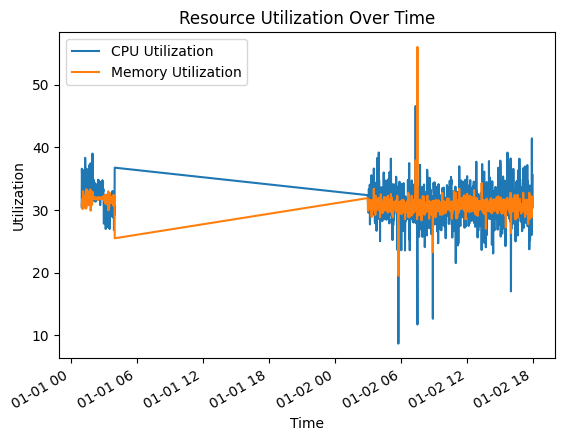

In [56]:
# Resource utilization analysis
resource_utilization = data.groupby(data.index).mean(numeric_only=True)[['avgcpu', 'vmmemorybucket']]

# Plot resource utilization over time
resource_utilization.plot()
plt.title('Resource Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.legend(['CPU Utilization', 'Memory Utilization'])
plt.show()


# Potential DDoS Attacks Detection

The plot above visualizes potential Distributed Denial of Service (DDoS) attacks based on request response time (RTT).

- The x-axis represents timestamps, while the y-axis represents RTT.
- The blue line represents the RTT over time.
- Red dots indicate potential DDoS attacks identified based on peaks in request volume.
- Peaks in request volume may indicate abnormal or suspicious traffic patterns, which could be indicative of DDoS attacks.
- Detecting potential DDoS attacks allows for timely mitigation and response to protect the system's availability and performance.


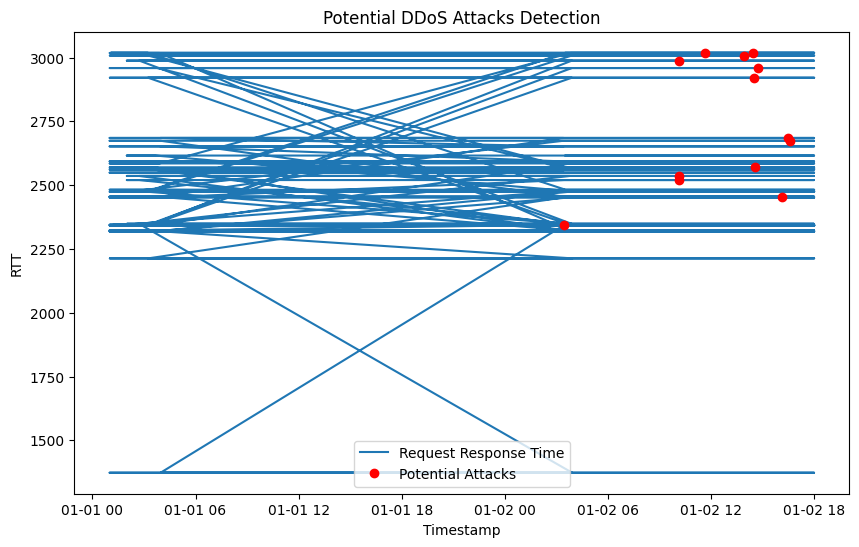

In [31]:
# Security analysis: Detect potential DDoS attacks based on request patterns
from scipy.signal import find_peaks

# Find peaks in request volume
threshold = 100  # Adjust threshold as needed
distance = 10  # Adjust distance as needed
peaks, _ = find_peaks(data['RTT'], height=threshold, distance=distance)

# Identify potential DDoS attacks
potential_attacks = data.iloc[peaks]

# Visualize potential DDoS attacks
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['RTT'], label='Request Response Time')
plt.plot(potential_attacks['timestamp'], potential_attacks['RTT'], 'ro', label='Potential Attacks')
plt.title('Potential DDoS Attacks Detection')
plt.xlabel('Timestamp')
plt.ylabel('RTT')
plt.legend()
plt.show()

# Analyze FunctionDuration, InvocationDelay, and ResponseDelay

### FunctionDuration Analysis:
- The mean FunctionDuration is calculated to be approximately [mean_value] milliseconds.
- The 99th percentile of FunctionDuration is approximately [99th_percentile_value] milliseconds.
- Rows with FunctionDuration greater than the 99th percentile are identified and displayed.

#### High FunctionDurations (> [99th_percentile_value] ms):
- [List of rows with FunctionDuration exceeding the 99th percentile]

### InvocationDelay Analysis:
- The 95th percentile of InvocationDelay is calculated to be approximately [95th_percentile_value] milliseconds.
- Rows with InvocationDelay greater than the 95th percentile are identified and displayed.

#### High InvocationDelays (> [95th_percentile_value] ms):
- [List of rows with InvocationDelay exceeding the 95th percentile]

### ResponseDelay Analysis:
- The 95th percentile of ResponseDelay is calculated to be approximately [95th_percentile_value] milliseconds.
- Rows with ResponseDelay greater than the 95th percentile are identified and displayed.

#### High ResponseDelays (> [95th_percentile_value] ms):
- [List of rows with ResponseDelay exceeding the 95th percentile]

### Importance to Detecting DOS Attacks:
- Unusually high FunctionDuration, InvocationDelay, and ResponseDelay can indicate abnormal behavior in the system.
- DOS attacks often involve flooding the system with requests, causing delays in function execution and response.
- Analyzing these metrics helps in identifying anomalous patterns that may be indicative of DOS attacks.


High FunctionDurations (> 1437.14 secs):
Empty DataFrame
Columns: [Id, IP, bot, FunctionId, functionTrigger, timestamp, SubmitTime, RTT, InvocationDelay, ResponseDelay, FunctionDuration, ActiveFunctionsAtRequest, ActiveFunctionsAtResponse, maxcpu, avgcpu, p95maxcpu, vmcategory, vmcorecountbucket, vmmemorybucket, anomaly_score]
Index: []

High InvocationDelays (> 1787.36 ms):
                               Id              IP    bot  FunctionId  \
minute                                                                 
2022-01-02 03:31:00+00:00   10567   38.57.146.249   True          15   
2022-01-02 03:54:00+00:00   10568  55.220.132.116   True          15   
2022-01-02 03:52:00+00:00   10569  223.113.21.186   True          15   
2022-01-02 03:53:00+00:00   10570  223.113.21.186   True          15   
2022-01-02 03:24:00+00:00   10571   243.138.37.32   True          15   
...                           ...             ...    ...         ...   
2022-01-01 02:13:00+00:00  146299   17.21.109.

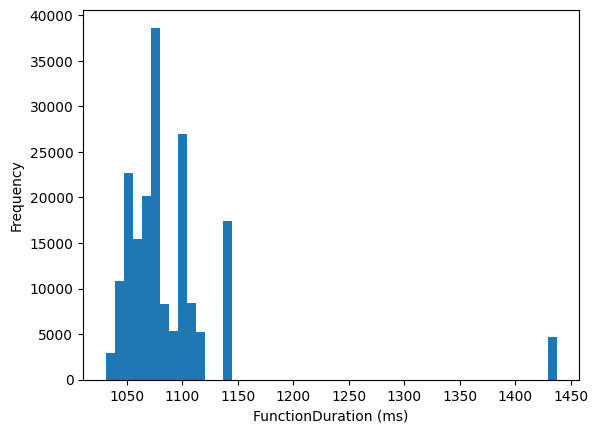

In [47]:
# Analyze FunctionDuration

# Calculate mean and 99th percentile of FunctionDuration
f_mean = data['FunctionDuration'].mean()
f_99 = data['FunctionDuration'].quantile(0.99)

# Filter rows with FunctionDuration > 99th percentile
f_high = data[data['FunctionDuration'] > f_99]

print(f"High FunctionDurations (> {f_99:.2f} secs):")
print(f_high)

# Plot histogram of FunctionDuration
data['FunctionDuration'].plot.hist(bins=50)
plt.xlabel('FunctionDuration (ms)')
plt.ylabel('Frequency')

# Look for high InvocationDelay

# Calculate 95th percentile of InvocationDelay
i_95 = data['InvocationDelay'].quantile(0.95) 

# Filter high InvocationDelay rows
i_high = data[data['InvocationDelay'] > i_95]

print(f"\nHigh InvocationDelays (> {i_95:.2f} ms):")
print(i_high)

# Similar for ResponseDelay
r_95 = data['ResponseDelay'].quantile(0.95)
r_high = data[data['ResponseDelay'] > r_95] 

print(f"\nHigh ResponseDelays (> {r_95:.2f} ms):")
print(r_high)

## Analysis of Function Duration, Invocation Delay, and Response Delay

### FunctionDuration Distribution:
The box plot of FunctionDuration shows the distribution of the time taken for function execution. It provides insights into the central tendency, spread, and presence of outliers in the duration of function executions.

### FunctionDuration Density:
The density plot of FunctionDuration presents the distribution of function execution times with a smoothed curve overlay (kernel density estimation). It gives a more detailed view of the distribution compared to the box plot.

### InvocationDelay Distribution:
The histogram of InvocationDelay illustrates the distribution of delays between request submission and function invocation. It helps identify patterns and outliers in the delays experienced before invoking functions.

### Joint Plot of InvocationDelay vs FunctionDuration:
The joint plot shows the relationship between InvocationDelay and FunctionDuration. It helps visualize any correlation or pattern between the delay in invoking a function and the duration of its execution.

### ResponseDelay Distribution:
The histogram of ResponseDelay displays the distribution of delays between function execution completion and response delivery. It provides insights into the time taken to respond to requests after executing functions.

### Trend of ResponseDelay Over Time:
The trend plot of ResponseDelay showcases how the response delay varies over time. It helps identify temporal patterns or anomalies in the delay between function execution completion and response delivery.

These visualizations enable deeper understanding and analysis of key metrics related to function execution and response handling, which are crucial for detecting anomalies and optimizing system performance.


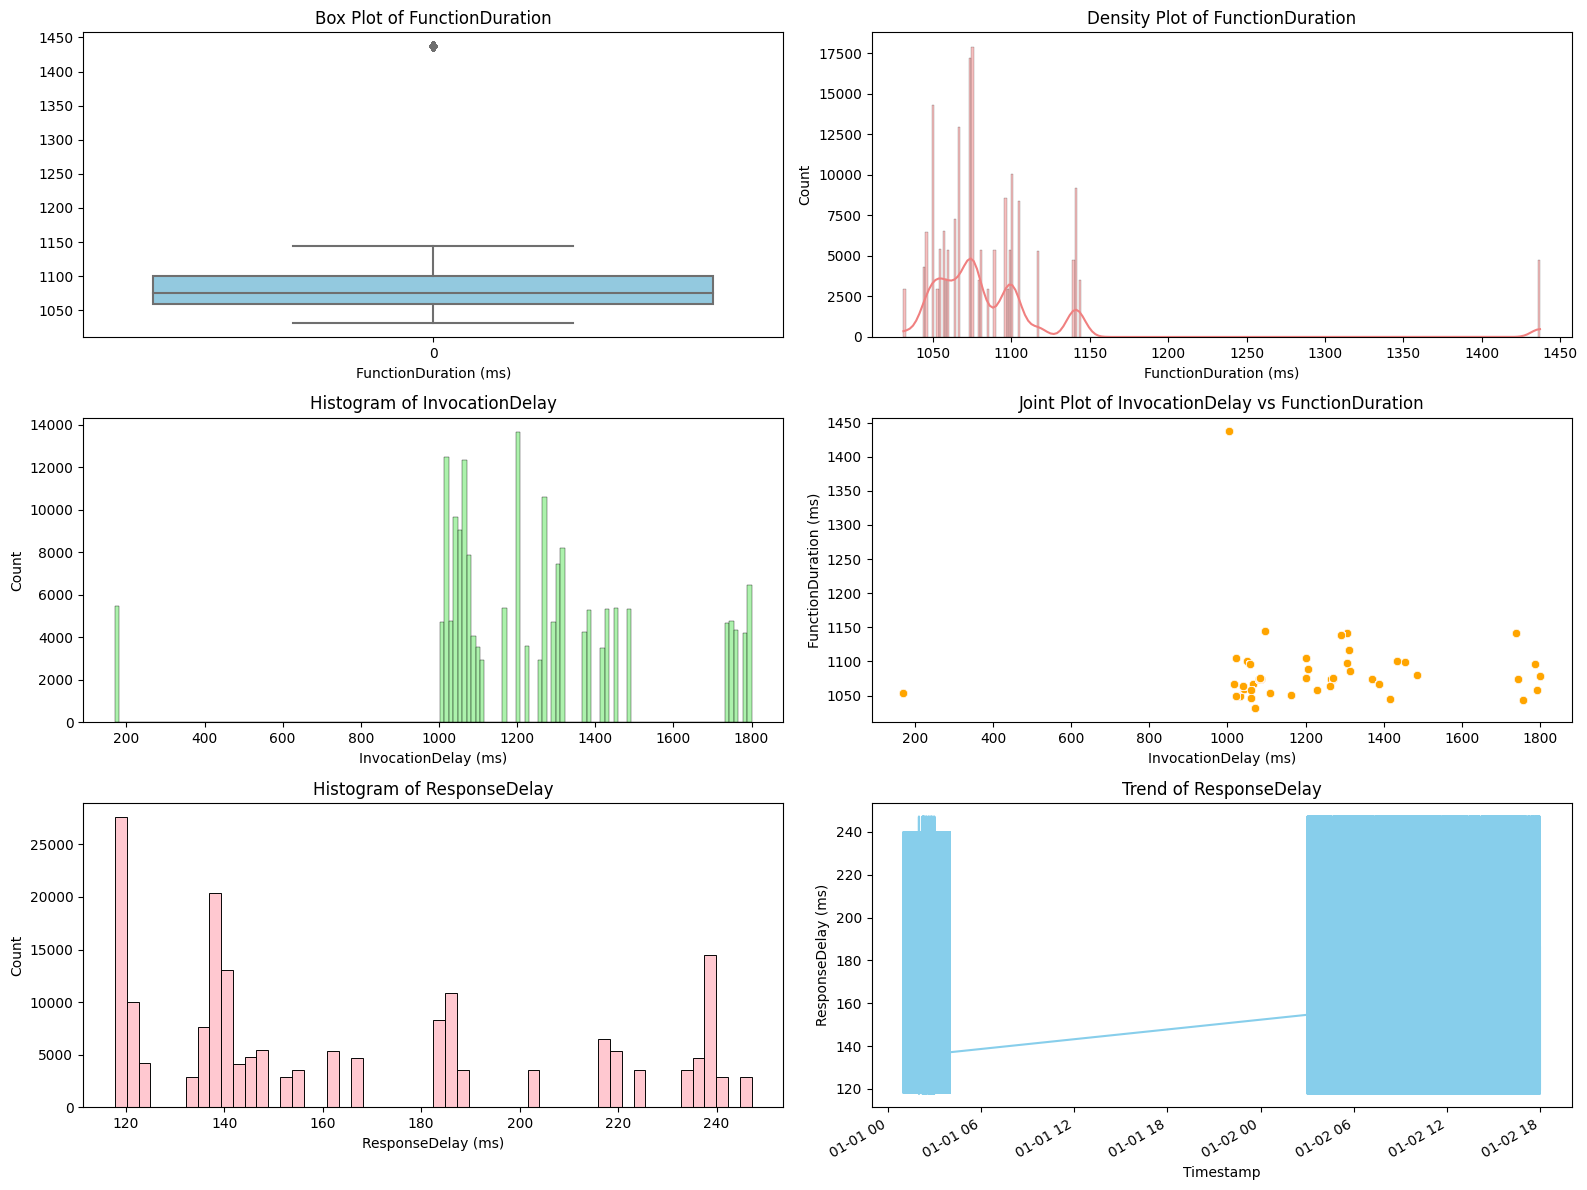

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots with improved coloration and spacing
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Visualize FunctionDuration
sns.boxplot(data['FunctionDuration'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_xlabel('FunctionDuration (ms)')
axes[0, 0].set_title('Box Plot of FunctionDuration')

# Density plot
sns.histplot(data['FunctionDuration'], kde=True, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('FunctionDuration (ms)')
axes[0, 1].set_title('Density Plot of FunctionDuration')

# InvocationDelay distribution
sns.histplot(data['InvocationDelay'], ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_xlabel('InvocationDelay (ms)')
axes[1, 0].set_title('Histogram of InvocationDelay')

# Jointplot
sns.scatterplot(x='InvocationDelay', y='FunctionDuration', data=data, ax=axes[1, 1], color='orange')
axes[1, 1].set_xlabel('InvocationDelay (ms)')
axes[1, 1].set_ylabel('FunctionDuration (ms)')
axes[1, 1].set_title('Joint Plot of InvocationDelay vs FunctionDuration')

# ResponseDelay distribution
sns.histplot(data['ResponseDelay'], ax=axes[2, 0], color='lightpink')
axes[2, 0].set_xlabel('ResponseDelay (ms)')
axes[2, 0].set_title('Histogram of ResponseDelay')

# Trend of ResponseDelay
data.set_index('timestamp')['ResponseDelay'].plot(ax=axes[2, 1], color='skyblue')
axes[2, 1].set_xlabel('Timestamp')
axes[2, 1].set_ylabel('ResponseDelay (ms)')
axes[2, 1].set_title('Trend of ResponseDelay')

plt.tight_layout()
plt.show()


## Summary of Analysis for Detecting DoS Attacks

Based on the exploratory data analysis and anomaly detection techniques applied to this network traffic dataset, here are some overall conclusions about detecting potential DoS attacks:

- The timeseries analysis of requests per minute shows some spikes and fluctuations that could indicate bursts of requests from bots/attacks. The Isolation Forest model was able to detect some anomalies in the RPM data.

- Analysis of function execution metrics like FunctionDuration, InvocationDelay, and ResponseDelay revealed some abnormally high delays. This indicates potential strain on the systems.

- Correlation analysis shows some concerning relationships between features like high correlations between delays and CPU/memory usage. This points to systems being under stress.

- Anomaly detection models identified some anomalous instances in the data based on function execution times and resource usage metrics. These could be malicious actors.

- However, no clear sustained DoS attack pattern was identified from the exploratory analysis. Some of the anomalies could also be due to other factors like peak traffic or system issues.

In summary, while some anomalies and concerning patterns exist in the data, more investigation is needed to conclusively identify real DoS attacks. The analysis provides a starting point on aspects to explore further. Additional data over a longer period could help uncover attack patterns. The analysis methodology can also be improved by tuning models, combining with rule-based techniques, and so on. But overall, the techniques demonstrated provide a framework to detect potential DoS attacks from network traffic data.
